# MDETR Model Interpretability with Attribution Guided Factorizatin

## Install Required Libraries (If Needed)

In [1]:
# !pip install timm transformers

In [2]:
import gc # for garbage collection used when CUDA is out of memory
import torch
from PIL import Image
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt
from hubconf import mdetr_efficientnetB5, mdetr_resnet101
from collections import defaultdict
import numpy as np
from skimage.measure import find_contours

from matplotlib import patches, lines
from matplotlib.patches import Polygon

import warnings
warnings.filterwarnings("ignore")

from utils import render
from data.imagenet_utils import CLS2IDX

In [3]:
# Check available GPU device.
!nvidia-smi

Fri Dec 17 18:21:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 165...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8     5W /  N/A |    533MiB /  3911MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Preliminaries

### Image Normalization

When read an image into memory, the pixels usually have 8-bit integers between $0$ and $255$ for all three channels. But regression models (including neural networks) prefer floating point values within a smaller range. A typical setup is a mean of $0$ and a standard deviation of $1$ like the standard normal distribution. This transformation for images is called *image normalization*.

For the details about the image normalizations in PyTorch please refer to: <https://sparrow.dev/pytorch-normalize/>.

In [4]:
# Standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Colors for Visualizations

In [5]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

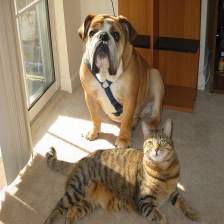

In [6]:
# Read an image from URL.
img_url = "https://github.com/shirgur/AGFVisualization/blob/master/samples/dog-cat.JPEG?raw=true"

# Fetch the image from raw response content.
# Refer to: https://docs.python-requests.org/en/latest/user/quickstart/#raw-response-content
img = Image.open(requests.get(img_url, stream=True).raw)

img


## Import the MDETR Model

In [7]:
# model, postprocessor = mdetr_efficientnetB5(pretrained=True, return_postprocessor=True)

model, postprocessor = mdetr_resnet101(
    pretrained=True, return_postprocessor=True)


odict_keys(['transformer.encoder.layers.0.self_attn.in_proj_weight', 'transformer.encoder.layers.0.self_attn.in_proj_bias', 'transformer.encoder.layers.0.self_attn.out_proj.weight', 'transformer.encoder.layers.0.self_attn.out_proj.bias', 'transformer.encoder.layers.0.linear1.weight', 'transformer.encoder.layers.0.linear1.bias', 'transformer.encoder.layers.0.linear2.weight', 'transformer.encoder.layers.0.linear2.bias', 'transformer.encoder.layers.0.norm1.weight', 'transformer.encoder.layers.0.norm1.bias', 'transformer.encoder.layers.0.norm2.weight', 'transformer.encoder.layers.0.norm2.bias', 'transformer.encoder.layers.1.self_attn.in_proj_weight', 'transformer.encoder.layers.1.self_attn.in_proj_bias', 'transformer.encoder.layers.1.self_attn.out_proj.weight', 'transformer.encoder.layers.1.self_attn.out_proj.bias', 'transformer.encoder.layers.1.linear1.weight', 'transformer.encoder.layers.1.linear1.bias', 'transformer.encoder.layers.1.linear2.weight', 'transformer.encoder.layers.1.linear2

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer3.6.conv1.weight", "layer3.6.bn1.weight", "layer3.6.bn1.bias", "layer3.6.bn1.running_mean", "layer3.6.bn1.running_var", "layer3.6.conv2.weight", "layer3.6.bn2.weight", "layer3.6.bn2.bias", "layer3.6.bn2.running_mean", "layer3.6.bn2.running_var", "layer3.6.conv3.weight", "layer3.6.bn3.weight", "layer3.6.bn3.bias", "layer3.6.bn3.running_mean", "layer3.6.bn3.running_var", "layer3.7.conv1.weight", "layer3.7.bn1.weight", "layer3.7.bn1.bias", "layer3.7.bn1.running_mean", "layer3.7.bn1.running_var", "layer3.7.conv2.weight", "layer3.7.bn2.weight", "layer3.7.bn2.bias", "layer3.7.bn2.running_mean", "layer3.7.bn2.running_var", "layer3.7.conv3.weight", "layer3.7.bn3.weight", "layer3.7.bn3.bias", "layer3.7.bn3.running_mean", "layer3.7.bn3.running_var", "layer3.8.conv1.weight", "layer3.8.bn1.weight", "layer3.8.bn1.bias", "layer3.8.bn1.running_mean", "layer3.8.bn1.running_var", "layer3.8.conv2.weight", "layer3.8.bn2.weight", "layer3.8.bn2.bias", "layer3.8.bn2.running_mean", "layer3.8.bn2.running_var", "layer3.8.conv3.weight", "layer3.8.bn3.weight", "layer3.8.bn3.bias", "layer3.8.bn3.running_mean", "layer3.8.bn3.running_var", "layer3.9.conv1.weight", "layer3.9.bn1.weight", "layer3.9.bn1.bias", "layer3.9.bn1.running_mean", "layer3.9.bn1.running_var", "layer3.9.conv2.weight", "layer3.9.bn2.weight", "layer3.9.bn2.bias", "layer3.9.bn2.running_mean", "layer3.9.bn2.running_var", "layer3.9.conv3.weight", "layer3.9.bn3.weight", "layer3.9.bn3.bias", "layer3.9.bn3.running_mean", "layer3.9.bn3.running_var", "layer3.10.conv1.weight", "layer3.10.bn1.weight", "layer3.10.bn1.bias", "layer3.10.bn1.running_mean", "layer3.10.bn1.running_var", "layer3.10.conv2.weight", "layer3.10.bn2.weight", "layer3.10.bn2.bias", "layer3.10.bn2.running_mean", "layer3.10.bn2.running_var", "layer3.10.conv3.weight", "layer3.10.bn3.weight", "layer3.10.bn3.bias", "layer3.10.bn3.running_mean", "layer3.10.bn3.running_var", "layer3.11.conv1.weight", "layer3.11.bn1.weight", "layer3.11.bn1.bias", "layer3.11.bn1.running_mean", "layer3.11.bn1.running_var", "layer3.11.conv2.weight", "layer3.11.bn2.weight", "layer3.11.bn2.bias", "layer3.11.bn2.running_mean", "layer3.11.bn2.running_var", "layer3.11.conv3.weight", "layer3.11.bn3.weight", "layer3.11.bn3.bias", "layer3.11.bn3.running_mean", "layer3.11.bn3.running_var", "layer3.12.conv1.weight", "layer3.12.bn1.weight", "layer3.12.bn1.bias", "layer3.12.bn1.running_mean", "layer3.12.bn1.running_var", "layer3.12.conv2.weight", "layer3.12.bn2.weight", "layer3.12.bn2.bias", "layer3.12.bn2.running_mean", "layer3.12.bn2.running_var", "layer3.12.conv3.weight", "layer3.12.bn3.weight", "layer3.12.bn3.bias", "layer3.12.bn3.running_mean", "layer3.12.bn3.running_var", "layer3.13.conv1.weight", "layer3.13.bn1.weight", "layer3.13.bn1.bias", "layer3.13.bn1.running_mean", "layer3.13.bn1.running_var", "layer3.13.conv2.weight", "layer3.13.bn2.weight", "layer3.13.bn2.bias", "layer3.13.bn2.running_mean", "layer3.13.bn2.running_var", "layer3.13.conv3.weight", "layer3.13.bn3.weight", "layer3.13.bn3.bias", "layer3.13.bn3.running_mean", "layer3.13.bn3.running_var", "layer3.14.conv1.weight", "layer3.14.bn1.weight", "layer3.14.bn1.bias", "layer3.14.bn1.running_mean", "layer3.14.bn1.running_var", "layer3.14.conv2.weight", "layer3.14.bn2.weight", "layer3.14.bn2.bias", "layer3.14.bn2.running_mean", "layer3.14.bn2.running_var", "layer3.14.conv3.weight", "layer3.14.bn3.weight", "layer3.14.bn3.bias", "layer3.14.bn3.running_mean", "layer3.14.bn3.running_var", "layer3.15.conv1.weight", "layer3.15.bn1.weight", "layer3.15.bn1.bias", "layer3.15.bn1.running_mean", "layer3.15.bn1.running_var", "layer3.15.conv2.weight", "layer3.15.bn2.weight", "layer3.15.bn2.bias", "layer3.15.bn2.running_mean", "layer3.15.bn2.running_var", "layer3.15.conv3.weight", "layer3.15.bn3.weight", "layer3.15.bn3.bias", "layer3.15.bn3.running_mean", "layer3.15.bn3.running_var", "layer3.16.conv1.weight", "layer3.16.bn1.weight", "layer3.16.bn1.bias", "layer3.16.bn1.running_mean", "layer3.16.bn1.running_var", "layer3.16.conv2.weight", "layer3.16.bn2.weight", "layer3.16.bn2.bias", "layer3.16.bn2.running_mean", "layer3.16.bn2.running_var", "layer3.16.conv3.weight", "layer3.16.bn3.weight", "layer3.16.bn3.bias", "layer3.16.bn3.running_mean", "layer3.16.bn3.running_var", "layer3.17.conv1.weight", "layer3.17.bn1.weight", "layer3.17.bn1.bias", "layer3.17.bn1.running_mean", "layer3.17.bn1.running_var", "layer3.17.conv2.weight", "layer3.17.bn2.weight", "layer3.17.bn2.bias", "layer3.17.bn2.running_mean", "layer3.17.bn2.running_var", "layer3.17.conv3.weight", "layer3.17.bn3.weight", "layer3.17.bn3.bias", "layer3.17.bn3.running_mean", "layer3.17.bn3.running_var", "layer3.18.conv1.weight", "layer3.18.bn1.weight", "layer3.18.bn1.bias", "layer3.18.bn1.running_mean", "layer3.18.bn1.running_var", "layer3.18.conv2.weight", "layer3.18.bn2.weight", "layer3.18.bn2.bias", "layer3.18.bn2.running_mean", "layer3.18.bn2.running_var", "layer3.18.conv3.weight", "layer3.18.bn3.weight", "layer3.18.bn3.bias", "layer3.18.bn3.running_mean", "layer3.18.bn3.running_var", "layer3.19.conv1.weight", "layer3.19.bn1.weight", "layer3.19.bn1.bias", "layer3.19.bn1.running_mean", "layer3.19.bn1.running_var", "layer3.19.conv2.weight", "layer3.19.bn2.weight", "layer3.19.bn2.bias", "layer3.19.bn2.running_mean", "layer3.19.bn2.running_var", "layer3.19.conv3.weight", "layer3.19.bn3.weight", "layer3.19.bn3.bias", "layer3.19.bn3.running_mean", "layer3.19.bn3.running_var", "layer3.20.conv1.weight", "layer3.20.bn1.weight", "layer3.20.bn1.bias", "layer3.20.bn1.running_mean", "layer3.20.bn1.running_var", "layer3.20.conv2.weight", "layer3.20.bn2.weight", "layer3.20.bn2.bias", "layer3.20.bn2.running_mean", "layer3.20.bn2.running_var", "layer3.20.conv3.weight", "layer3.20.bn3.weight", "layer3.20.bn3.bias", "layer3.20.bn3.running_mean", "layer3.20.bn3.running_var", "layer3.21.conv1.weight", "layer3.21.bn1.weight", "layer3.21.bn1.bias", "layer3.21.bn1.running_mean", "layer3.21.bn1.running_var", "layer3.21.conv2.weight", "layer3.21.bn2.weight", "layer3.21.bn2.bias", "layer3.21.bn2.running_mean", "layer3.21.bn2.running_var", "layer3.21.conv3.weight", "layer3.21.bn3.weight", "layer3.21.bn3.bias", "layer3.21.bn3.running_mean", "layer3.21.bn3.running_var", "layer3.22.conv1.weight", "layer3.22.bn1.weight", "layer3.22.bn1.bias", "layer3.22.bn1.running_mean", "layer3.22.bn1.running_var", "layer3.22.conv2.weight", "layer3.22.bn2.weight", "layer3.22.bn2.bias", "layer3.22.bn2.running_mean", "layer3.22.bn2.running_var", "layer3.22.conv3.weight", "layer3.22.bn3.weight", "layer3.22.bn3.bias", "layer3.22.bn3.running_mean", "layer3.22.bn3.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "transformer.encoder.layers.0.self_attn.in_proj_weight", "transformer.encoder.layers.0.self_attn.in_proj_bias", "transformer.encoder.layers.0.self_attn.out_proj.weight", "transformer.encoder.layers.0.self_attn.out_proj.bias", "transformer.encoder.layers.0.linear1.weight", "transformer.encoder.layers.0.linear1.bias", "transformer.encoder.layers.0.linear2.weight", "transformer.encoder.layers.0.linear2.bias", "transformer.encoder.layers.0.norm1.weight", "transformer.encoder.layers.0.norm1.bias", "transformer.encoder.layers.0.norm2.weight", "transformer.encoder.layers.0.norm2.bias", "transformer.encoder.layers.1.self_attn.in_proj_weight", "transformer.encoder.layers.1.self_attn.in_proj_bias", "transformer.encoder.layers.1.self_attn.out_proj.weight", "transformer.encoder.layers.1.self_attn.out_proj.bias", "transformer.encoder.layers.1.linear1.weight", "transformer.encoder.layers.1.linear1.bias", "transformer.encoder.layers.1.linear2.weight", "transformer.encoder.layers.1.linear2.bias", "transformer.encoder.layers.1.norm1.weight", "transformer.encoder.layers.1.norm1.bias", "transformer.encoder.layers.1.norm2.weight", "transformer.encoder.layers.1.norm2.bias", "transformer.encoder.layers.2.self_attn.in_proj_weight", "transformer.encoder.layers.2.self_attn.in_proj_bias", "transformer.encoder.layers.2.self_attn.out_proj.weight", "transformer.encoder.layers.2.self_attn.out_proj.bias", "transformer.encoder.layers.2.linear1.weight", "transformer.encoder.layers.2.linear1.bias", "transformer.encoder.layers.2.linear2.weight", "transformer.encoder.layers.2.linear2.bias", "transformer.encoder.layers.2.norm1.weight", "transformer.encoder.layers.2.norm1.bias", "transformer.encoder.layers.2.norm2.weight", "transformer.encoder.layers.2.norm2.bias", "transformer.encoder.layers.3.self_attn.in_proj_weight", "transformer.encoder.layers.3.self_attn.in_proj_bias", "transformer.encoder.layers.3.self_attn.out_proj.weight", "transformer.encoder.layers.3.self_attn.out_proj.bias", "transformer.encoder.layers.3.linear1.weight", "transformer.encoder.layers.3.linear1.bias", "transformer.encoder.layers.3.linear2.weight", "transformer.encoder.layers.3.linear2.bias", "transformer.encoder.layers.3.norm1.weight", "transformer.encoder.layers.3.norm1.bias", "transformer.encoder.layers.3.norm2.weight", "transformer.encoder.layers.3.norm2.bias", "transformer.encoder.layers.4.self_attn.in_proj_weight", "transformer.encoder.layers.4.self_attn.in_proj_bias", "transformer.encoder.layers.4.self_attn.out_proj.weight", "transformer.encoder.layers.4.self_attn.out_proj.bias", "transformer.encoder.layers.4.linear1.weight", "transformer.encoder.layers.4.linear1.bias", "transformer.encoder.layers.4.linear2.weight", "transformer.encoder.layers.4.linear2.bias", "transformer.encoder.layers.4.norm1.weight", "transformer.encoder.layers.4.norm1.bias", "transformer.encoder.layers.4.norm2.weight", "transformer.encoder.layers.4.norm2.bias", "transformer.encoder.layers.5.self_attn.in_proj_weight", "transformer.encoder.layers.5.self_attn.in_proj_bias", "transformer.encoder.layers.5.self_attn.out_proj.weight", "transformer.encoder.layers.5.self_attn.out_proj.bias", "transformer.encoder.layers.5.linear1.weight", "transformer.encoder.layers.5.linear1.bias", "transformer.encoder.layers.5.linear2.weight", "transformer.encoder.layers.5.linear2.bias", "transformer.encoder.layers.5.norm1.weight", "transformer.encoder.layers.5.norm1.bias", "transformer.encoder.layers.5.norm2.weight", "transformer.encoder.layers.5.norm2.bias", "transformer.decoder.layers.0.self_attn.in_proj_weight", "transformer.decoder.layers.0.self_attn.in_proj_bias", "transformer.decoder.layers.0.self_attn.out_proj.weight", "transformer.decoder.layers.0.self_attn.out_proj.bias", "transformer.decoder.layers.0.cross_attn_image.in_proj_weight", "transformer.decoder.layers.0.cross_attn_image.in_proj_bias", "transformer.decoder.layers.0.cross_attn_image.out_proj.weight", "transformer.decoder.layers.0.cross_attn_image.out_proj.bias", "transformer.decoder.layers.0.linear1.weight", "transformer.decoder.layers.0.linear1.bias", "transformer.decoder.layers.0.linear2.weight", "transformer.decoder.layers.0.linear2.bias", "transformer.decoder.layers.0.norm1.weight", "transformer.decoder.layers.0.norm1.bias", "transformer.decoder.layers.0.norm3.weight", "transformer.decoder.layers.0.norm3.bias", "transformer.decoder.layers.0.norm4.weight", "transformer.decoder.layers.0.norm4.bias", "transformer.decoder.layers.1.self_attn.in_proj_weight", "transformer.decoder.layers.1.self_attn.in_proj_bias", "transformer.decoder.layers.1.self_attn.out_proj.weight", "transformer.decoder.layers.1.self_attn.out_proj.bias", "transformer.decoder.layers.1.cross_attn_image.in_proj_weight", "transformer.decoder.layers.1.cross_attn_image.in_proj_bias", "transformer.decoder.layers.1.cross_attn_image.out_proj.weight", "transformer.decoder.layers.1.cross_attn_image.out_proj.bias", "transformer.decoder.layers.1.linear1.weight", "transformer.decoder.layers.1.linear1.bias", "transformer.decoder.layers.1.linear2.weight", "transformer.decoder.layers.1.linear2.bias", "transformer.decoder.layers.1.norm1.weight", "transformer.decoder.layers.1.norm1.bias", "transformer.decoder.layers.1.norm3.weight", "transformer.decoder.layers.1.norm3.bias", "transformer.decoder.layers.1.norm4.weight", "transformer.decoder.layers.1.norm4.bias", "transformer.decoder.layers.2.self_attn.in_proj_weight", "transformer.decoder.layers.2.self_attn.in_proj_bias", "transformer.decoder.layers.2.self_attn.out_proj.weight", "transformer.decoder.layers.2.self_attn.out_proj.bias", "transformer.decoder.layers.2.cross_attn_image.in_proj_weight", "transformer.decoder.layers.2.cross_attn_image.in_proj_bias", "transformer.decoder.layers.2.cross_attn_image.out_proj.weight", "transformer.decoder.layers.2.cross_attn_image.out_proj.bias", "transformer.decoder.layers.2.linear1.weight", "transformer.decoder.layers.2.linear1.bias", "transformer.decoder.layers.2.linear2.weight", "transformer.decoder.layers.2.linear2.bias", "transformer.decoder.layers.2.norm1.weight", "transformer.decoder.layers.2.norm1.bias", "transformer.decoder.layers.2.norm3.weight", "transformer.decoder.layers.2.norm3.bias", "transformer.decoder.layers.2.norm4.weight", "transformer.decoder.layers.2.norm4.bias", "transformer.decoder.layers.3.self_attn.in_proj_weight", "transformer.decoder.layers.3.self_attn.in_proj_bias", "transformer.decoder.layers.3.self_attn.out_proj.weight", "transformer.decoder.layers.3.self_attn.out_proj.bias", "transformer.decoder.layers.3.cross_attn_image.in_proj_weight", "transformer.decoder.layers.3.cross_attn_image.in_proj_bias", "transformer.decoder.layers.3.cross_attn_image.out_proj.weight", "transformer.decoder.layers.3.cross_attn_image.out_proj.bias", "transformer.decoder.layers.3.linear1.weight", "transformer.decoder.layers.3.linear1.bias", "transformer.decoder.layers.3.linear2.weight", "transformer.decoder.layers.3.linear2.bias", "transformer.decoder.layers.3.norm1.weight", "transformer.decoder.layers.3.norm1.bias", "transformer.decoder.layers.3.norm3.weight", "transformer.decoder.layers.3.norm3.bias", "transformer.decoder.layers.3.norm4.weight", "transformer.decoder.layers.3.norm4.bias", "transformer.decoder.layers.4.self_attn.in_proj_weight", "transformer.decoder.layers.4.self_attn.in_proj_bias", "transformer.decoder.layers.4.self_attn.out_proj.weight", "transformer.decoder.layers.4.self_attn.out_proj.bias", "transformer.decoder.layers.4.cross_attn_image.in_proj_weight", "transformer.decoder.layers.4.cross_attn_image.in_proj_bias", "transformer.decoder.layers.4.cross_attn_image.out_proj.weight", "transformer.decoder.layers.4.cross_attn_image.out_proj.bias", "transformer.decoder.layers.4.linear1.weight", "transformer.decoder.layers.4.linear1.bias", "transformer.decoder.layers.4.linear2.weight", "transformer.decoder.layers.4.linear2.bias", "transformer.decoder.layers.4.norm1.weight", "transformer.decoder.layers.4.norm1.bias", "transformer.decoder.layers.4.norm3.weight", "transformer.decoder.layers.4.norm3.bias", "transformer.decoder.layers.4.norm4.weight", "transformer.decoder.layers.4.norm4.bias", "transformer.decoder.layers.5.self_attn.in_proj_weight", "transformer.decoder.layers.5.self_attn.in_proj_bias", "transformer.decoder.layers.5.self_attn.out_proj.weight", "transformer.decoder.layers.5.self_attn.out_proj.bias", "transformer.decoder.layers.5.cross_attn_image.in_proj_weight", "transformer.decoder.layers.5.cross_attn_image.in_proj_bias", "transformer.decoder.layers.5.cross_attn_image.out_proj.weight", "transformer.decoder.layers.5.cross_attn_image.out_proj.bias", "transformer.decoder.layers.5.linear1.weight", "transformer.decoder.layers.5.linear1.bias", "transformer.decoder.layers.5.linear2.weight", "transformer.decoder.layers.5.linear2.bias", "transformer.decoder.layers.5.norm1.weight", "transformer.decoder.layers.5.norm1.bias", "transformer.decoder.layers.5.norm3.weight", "transformer.decoder.layers.5.norm3.bias", "transformer.decoder.layers.5.norm4.weight", "transformer.decoder.layers.5.norm4.bias", "transformer.decoder.norm.weight", "transformer.decoder.norm.bias", "transformer.text_encoder.embeddings.position_ids", "transformer.text_encoder.embeddings.word_embeddings.weight", "transformer.text_encoder.embeddings.position_embeddings.weight", "transformer.text_encoder.embeddings.token_type_embeddings.weight", "transformer.text_encoder.embeddings.LayerNorm.weight", "transformer.text_encoder.embeddings.LayerNorm.bias", "transformer.text_encoder.encoder.layer.0.attention.self.query.weight", "transformer.text_encoder.encoder.layer.0.attention.self.query.bias", "transformer.text_encoder.encoder.layer.0.attention.self.key.weight", "transformer.text_encoder.encoder.layer.0.attention.self.key.bias", "transformer.text_encoder.encoder.layer.0.attention.self.value.weight", "transformer.text_encoder.encoder.layer.0.attention.self.value.bias", "transformer.text_encoder.encoder.layer.0.attention.output.dense.weight", "transformer.text_encoder.encoder.layer.0.attention.output.dense.bias", "transformer.text_encoder.encoder.layer.0.attention.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.0.attention.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.0.intermediate.dense.weight", "transformer.text_encoder.encoder.layer.0.intermediate.dense.bias", "transformer.text_encoder.encoder.layer.0.output.dense.weight", "transformer.text_encoder.encoder.layer.0.output.dense.bias", "transformer.text_encoder.encoder.layer.0.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.0.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.1.attention.self.query.weight", "transformer.text_encoder.encoder.layer.1.attention.self.query.bias", "transformer.text_encoder.encoder.layer.1.attention.self.key.weight", "transformer.text_encoder.encoder.layer.1.attention.self.key.bias", "transformer.text_encoder.encoder.layer.1.attention.self.value.weight", "transformer.text_encoder.encoder.layer.1.attention.self.value.bias", "transformer.text_encoder.encoder.layer.1.attention.output.dense.weight", "transformer.text_encoder.encoder.layer.1.attention.output.dense.bias", "transformer.text_encoder.encoder.layer.1.attention.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.1.attention.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.1.intermediate.dense.weight", "transformer.text_encoder.encoder.layer.1.intermediate.dense.bias", "transformer.text_encoder.encoder.layer.1.output.dense.weight", "transformer.text_encoder.encoder.layer.1.output.dense.bias", "transformer.text_encoder.encoder.layer.1.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.1.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.2.attention.self.query.weight", "transformer.text_encoder.encoder.layer.2.attention.self.query.bias", "transformer.text_encoder.encoder.layer.2.attention.self.key.weight", "transformer.text_encoder.encoder.layer.2.attention.self.key.bias", "transformer.text_encoder.encoder.layer.2.attention.self.value.weight", "transformer.text_encoder.encoder.layer.2.attention.self.value.bias", "transformer.text_encoder.encoder.layer.2.attention.output.dense.weight", "transformer.text_encoder.encoder.layer.2.attention.output.dense.bias", "transformer.text_encoder.encoder.layer.2.attention.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.2.attention.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.2.intermediate.dense.weight", "transformer.text_encoder.encoder.layer.2.intermediate.dense.bias", "transformer.text_encoder.encoder.layer.2.output.dense.weight", "transformer.text_encoder.encoder.layer.2.output.dense.bias", "transformer.text_encoder.encoder.layer.2.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.2.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.3.attention.self.query.weight", "transformer.text_encoder.encoder.layer.3.attention.self.query.bias", "transformer.text_encoder.encoder.layer.3.attention.self.key.weight", "transformer.text_encoder.encoder.layer.3.attention.self.key.bias", "transformer.text_encoder.encoder.layer.3.attention.self.value.weight", "transformer.text_encoder.encoder.layer.3.attention.self.value.bias", "transformer.text_encoder.encoder.layer.3.attention.output.dense.weight", "transformer.text_encoder.encoder.layer.3.attention.output.dense.bias", "transformer.text_encoder.encoder.layer.3.attention.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.3.attention.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.3.intermediate.dense.weight", "transformer.text_encoder.encoder.layer.3.intermediate.dense.bias", "transformer.text_encoder.encoder.layer.3.output.dense.weight", "transformer.text_encoder.encoder.layer.3.output.dense.bias", "transformer.text_encoder.encoder.layer.3.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.3.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.4.attention.self.query.weight", "transformer.text_encoder.encoder.layer.4.attention.self.query.bias", "transformer.text_encoder.encoder.layer.4.attention.self.key.weight", "transformer.text_encoder.encoder.layer.4.attention.self.key.bias", "transformer.text_encoder.encoder.layer.4.attention.self.value.weight", "transformer.text_encoder.encoder.layer.4.attention.self.value.bias", "transformer.text_encoder.encoder.layer.4.attention.output.dense.weight", "transformer.text_encoder.encoder.layer.4.attention.output.dense.bias", "transformer.text_encoder.encoder.layer.4.attention.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.4.attention.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.4.intermediate.dense.weight", "transformer.text_encoder.encoder.layer.4.intermediate.dense.bias", "transformer.text_encoder.encoder.layer.4.output.dense.weight", "transformer.text_encoder.encoder.layer.4.output.dense.bias", "transformer.text_encoder.encoder.layer.4.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.4.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.5.attention.self.query.weight", "transformer.text_encoder.encoder.layer.5.attention.self.query.bias", "transformer.text_encoder.encoder.layer.5.attention.self.key.weight", "transformer.text_encoder.encoder.layer.5.attention.self.key.bias", "transformer.text_encoder.encoder.layer.5.attention.self.value.weight", "transformer.text_encoder.encoder.layer.5.attention.self.value.bias", "transformer.text_encoder.encoder.layer.5.attention.output.dense.weight", "transformer.text_encoder.encoder.layer.5.attention.output.dense.bias", "transformer.text_encoder.encoder.layer.5.attention.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.5.attention.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.5.intermediate.dense.weight", "transformer.text_encoder.encoder.layer.5.intermediate.dense.bias", "transformer.text_encoder.encoder.layer.5.output.dense.weight", "transformer.text_encoder.encoder.layer.5.output.dense.bias", "transformer.text_encoder.encoder.layer.5.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.5.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.6.attention.self.query.weight", "transformer.text_encoder.encoder.layer.6.attention.self.query.bias", "transformer.text_encoder.encoder.layer.6.attention.self.key.weight", "transformer.text_encoder.encoder.layer.6.attention.self.key.bias", "transformer.text_encoder.encoder.layer.6.attention.self.value.weight", "transformer.text_encoder.encoder.layer.6.attention.self.value.bias", "transformer.text_encoder.encoder.layer.6.attention.output.dense.weight", "transformer.text_encoder.encoder.layer.6.attention.output.dense.bias", "transformer.text_encoder.encoder.layer.6.attention.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.6.attention.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.6.intermediate.dense.weight", "transformer.text_encoder.encoder.layer.6.intermediate.dense.bias", "transformer.text_encoder.encoder.layer.6.output.dense.weight", "transformer.text_encoder.encoder.layer.6.output.dense.bias", "transformer.text_encoder.encoder.layer.6.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.6.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.7.attention.self.query.weight", "transformer.text_encoder.encoder.layer.7.attention.self.query.bias", "transformer.text_encoder.encoder.layer.7.attention.self.key.weight", "transformer.text_encoder.encoder.layer.7.attention.self.key.bias", "transformer.text_encoder.encoder.layer.7.attention.self.value.weight", "transformer.text_encoder.encoder.layer.7.attention.self.value.bias", "transformer.text_encoder.encoder.layer.7.attention.output.dense.weight", "transformer.text_encoder.encoder.layer.7.attention.output.dense.bias", "transformer.text_encoder.encoder.layer.7.attention.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.7.attention.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.7.intermediate.dense.weight", "transformer.text_encoder.encoder.layer.7.intermediate.dense.bias", "transformer.text_encoder.encoder.layer.7.output.dense.weight", "transformer.text_encoder.encoder.layer.7.output.dense.bias", "transformer.text_encoder.encoder.layer.7.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.7.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.8.attention.self.query.weight", "transformer.text_encoder.encoder.layer.8.attention.self.query.bias", "transformer.text_encoder.encoder.layer.8.attention.self.key.weight", "transformer.text_encoder.encoder.layer.8.attention.self.key.bias", "transformer.text_encoder.encoder.layer.8.attention.self.value.weight", "transformer.text_encoder.encoder.layer.8.attention.self.value.bias", "transformer.text_encoder.encoder.layer.8.attention.output.dense.weight", "transformer.text_encoder.encoder.layer.8.attention.output.dense.bias", "transformer.text_encoder.encoder.layer.8.attention.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.8.attention.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.8.intermediate.dense.weight", "transformer.text_encoder.encoder.layer.8.intermediate.dense.bias", "transformer.text_encoder.encoder.layer.8.output.dense.weight", "transformer.text_encoder.encoder.layer.8.output.dense.bias", "transformer.text_encoder.encoder.layer.8.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.8.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.9.attention.self.query.weight", "transformer.text_encoder.encoder.layer.9.attention.self.query.bias", "transformer.text_encoder.encoder.layer.9.attention.self.key.weight", "transformer.text_encoder.encoder.layer.9.attention.self.key.bias", "transformer.text_encoder.encoder.layer.9.attention.self.value.weight", "transformer.text_encoder.encoder.layer.9.attention.self.value.bias", "transformer.text_encoder.encoder.layer.9.attention.output.dense.weight", "transformer.text_encoder.encoder.layer.9.attention.output.dense.bias", "transformer.text_encoder.encoder.layer.9.attention.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.9.attention.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.9.intermediate.dense.weight", "transformer.text_encoder.encoder.layer.9.intermediate.dense.bias", "transformer.text_encoder.encoder.layer.9.output.dense.weight", "transformer.text_encoder.encoder.layer.9.output.dense.bias", "transformer.text_encoder.encoder.layer.9.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.9.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.10.attention.self.query.weight", "transformer.text_encoder.encoder.layer.10.attention.self.query.bias", "transformer.text_encoder.encoder.layer.10.attention.self.key.weight", "transformer.text_encoder.encoder.layer.10.attention.self.key.bias", "transformer.text_encoder.encoder.layer.10.attention.self.value.weight", "transformer.text_encoder.encoder.layer.10.attention.self.value.bias", "transformer.text_encoder.encoder.layer.10.attention.output.dense.weight", "transformer.text_encoder.encoder.layer.10.attention.output.dense.bias", "transformer.text_encoder.encoder.layer.10.attention.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.10.attention.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.10.intermediate.dense.weight", "transformer.text_encoder.encoder.layer.10.intermediate.dense.bias", "transformer.text_encoder.encoder.layer.10.output.dense.weight", "transformer.text_encoder.encoder.layer.10.output.dense.bias", "transformer.text_encoder.encoder.layer.10.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.10.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.11.attention.self.query.weight", "transformer.text_encoder.encoder.layer.11.attention.self.query.bias", "transformer.text_encoder.encoder.layer.11.attention.self.key.weight", "transformer.text_encoder.encoder.layer.11.attention.self.key.bias", "transformer.text_encoder.encoder.layer.11.attention.self.value.weight", "transformer.text_encoder.encoder.layer.11.attention.self.value.bias", "transformer.text_encoder.encoder.layer.11.attention.output.dense.weight", "transformer.text_encoder.encoder.layer.11.attention.output.dense.bias", "transformer.text_encoder.encoder.layer.11.attention.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.11.attention.output.LayerNorm.bias", "transformer.text_encoder.encoder.layer.11.intermediate.dense.weight", "transformer.text_encoder.encoder.layer.11.intermediate.dense.bias", "transformer.text_encoder.encoder.layer.11.output.dense.weight", "transformer.text_encoder.encoder.layer.11.output.dense.bias", "transformer.text_encoder.encoder.layer.11.output.LayerNorm.weight", "transformer.text_encoder.encoder.layer.11.output.LayerNorm.bias", "transformer.text_encoder.pooler.dense.weight", "transformer.text_encoder.pooler.dense.bias", "transformer.resizer.fc.weight", "transformer.resizer.fc.bias", "transformer.resizer.layer_norm.weight", "transformer.resizer.layer_norm.bias", "class_embed.weight", "class_embed.bias", "bbox_embed.layers.0.weight", "bbox_embed.layers.0.bias", "bbox_embed.layers.1.weight", "bbox_embed.layers.1.bias", "bbox_embed.layers.2.weight", "bbox_embed.layers.2.bias", "query_embed.weight", "input_proj.weight", "input_proj.bias", "backbone.0.body.conv1.weight", "backbone.0.body.bn1.weight", "backbone.0.body.bn1.bias", "backbone.0.body.bn1.running_mean", "backbone.0.body.bn1.running_var", "backbone.0.body.layer1.0.conv1.weight", "backbone.0.body.layer1.0.bn1.weight", "backbone.0.body.layer1.0.bn1.bias", "backbone.0.body.layer1.0.bn1.running_mean", "backbone.0.body.layer1.0.bn1.running_var", "backbone.0.body.layer1.0.conv2.weight", "backbone.0.body.layer1.0.bn2.weight", "backbone.0.body.layer1.0.bn2.bias", "backbone.0.body.layer1.0.bn2.running_mean", "backbone.0.body.layer1.0.bn2.running_var", "backbone.0.body.layer1.0.conv3.weight", "backbone.0.body.layer1.0.bn3.weight", "backbone.0.body.layer1.0.bn3.bias", "backbone.0.body.layer1.0.bn3.running_mean", "backbone.0.body.layer1.0.bn3.running_var", "backbone.0.body.layer1.0.downsample.0.weight", "backbone.0.body.layer1.0.downsample.1.weight", "backbone.0.body.layer1.0.downsample.1.bias", "backbone.0.body.layer1.0.downsample.1.running_mean", "backbone.0.body.layer1.0.downsample.1.running_var", "backbone.0.body.layer1.1.conv1.weight", "backbone.0.body.layer1.1.bn1.weight", "backbone.0.body.layer1.1.bn1.bias", "backbone.0.body.layer1.1.bn1.running_mean", "backbone.0.body.layer1.1.bn1.running_var", "backbone.0.body.layer1.1.conv2.weight", "backbone.0.body.layer1.1.bn2.weight", "backbone.0.body.layer1.1.bn2.bias", "backbone.0.body.layer1.1.bn2.running_mean", "backbone.0.body.layer1.1.bn2.running_var", "backbone.0.body.layer1.1.conv3.weight", "backbone.0.body.layer1.1.bn3.weight", "backbone.0.body.layer1.1.bn3.bias", "backbone.0.body.layer1.1.bn3.running_mean", "backbone.0.body.layer1.1.bn3.running_var", "backbone.0.body.layer1.2.conv1.weight", "backbone.0.body.layer1.2.bn1.weight", "backbone.0.body.layer1.2.bn1.bias", "backbone.0.body.layer1.2.bn1.running_mean", "backbone.0.body.layer1.2.bn1.running_var", "backbone.0.body.layer1.2.conv2.weight", "backbone.0.body.layer1.2.bn2.weight", "backbone.0.body.layer1.2.bn2.bias", "backbone.0.body.layer1.2.bn2.running_mean", "backbone.0.body.layer1.2.bn2.running_var", "backbone.0.body.layer1.2.conv3.weight", "backbone.0.body.layer1.2.bn3.weight", "backbone.0.body.layer1.2.bn3.bias", "backbone.0.body.layer1.2.bn3.running_mean", "backbone.0.body.layer1.2.bn3.running_var", "backbone.0.body.layer2.0.conv1.weight", "backbone.0.body.layer2.0.bn1.weight", "backbone.0.body.layer2.0.bn1.bias", "backbone.0.body.layer2.0.bn1.running_mean", "backbone.0.body.layer2.0.bn1.running_var", "backbone.0.body.layer2.0.conv2.weight", "backbone.0.body.layer2.0.bn2.weight", "backbone.0.body.layer2.0.bn2.bias", "backbone.0.body.layer2.0.bn2.running_mean", "backbone.0.body.layer2.0.bn2.running_var", "backbone.0.body.layer2.0.conv3.weight", "backbone.0.body.layer2.0.bn3.weight", "backbone.0.body.layer2.0.bn3.bias", "backbone.0.body.layer2.0.bn3.running_mean", "backbone.0.body.layer2.0.bn3.running_var", "backbone.0.body.layer2.0.downsample.0.weight", "backbone.0.body.layer2.0.downsample.1.weight", "backbone.0.body.layer2.0.downsample.1.bias", "backbone.0.body.layer2.0.downsample.1.running_mean", "backbone.0.body.layer2.0.downsample.1.running_var", "backbone.0.body.layer2.1.conv1.weight", "backbone.0.body.layer2.1.bn1.weight", "backbone.0.body.layer2.1.bn1.bias", "backbone.0.body.layer2.1.bn1.running_mean", "backbone.0.body.layer2.1.bn1.running_var", "backbone.0.body.layer2.1.conv2.weight", "backbone.0.body.layer2.1.bn2.weight", "backbone.0.body.layer2.1.bn2.bias", "backbone.0.body.layer2.1.bn2.running_mean", "backbone.0.body.layer2.1.bn2.running_var", "backbone.0.body.layer2.1.conv3.weight", "backbone.0.body.layer2.1.bn3.weight", "backbone.0.body.layer2.1.bn3.bias", "backbone.0.body.layer2.1.bn3.running_mean", "backbone.0.body.layer2.1.bn3.running_var", "backbone.0.body.layer2.2.conv1.weight", "backbone.0.body.layer2.2.bn1.weight", "backbone.0.body.layer2.2.bn1.bias", "backbone.0.body.layer2.2.bn1.running_mean", "backbone.0.body.layer2.2.bn1.running_var", "backbone.0.body.layer2.2.conv2.weight", "backbone.0.body.layer2.2.bn2.weight", "backbone.0.body.layer2.2.bn2.bias", "backbone.0.body.layer2.2.bn2.running_mean", "backbone.0.body.layer2.2.bn2.running_var", "backbone.0.body.layer2.2.conv3.weight", "backbone.0.body.layer2.2.bn3.weight", "backbone.0.body.layer2.2.bn3.bias", "backbone.0.body.layer2.2.bn3.running_mean", "backbone.0.body.layer2.2.bn3.running_var", "backbone.0.body.layer2.3.conv1.weight", "backbone.0.body.layer2.3.bn1.weight", "backbone.0.body.layer2.3.bn1.bias", "backbone.0.body.layer2.3.bn1.running_mean", "backbone.0.body.layer2.3.bn1.running_var", "backbone.0.body.layer2.3.conv2.weight", "backbone.0.body.layer2.3.bn2.weight", "backbone.0.body.layer2.3.bn2.bias", "backbone.0.body.layer2.3.bn2.running_mean", "backbone.0.body.layer2.3.bn2.running_var", "backbone.0.body.layer2.3.conv3.weight", "backbone.0.body.layer2.3.bn3.weight", "backbone.0.body.layer2.3.bn3.bias", "backbone.0.body.layer2.3.bn3.running_mean", "backbone.0.body.layer2.3.bn3.running_var", "backbone.0.body.layer3.0.conv1.weight", "backbone.0.body.layer3.0.bn1.weight", "backbone.0.body.layer3.0.bn1.bias", "backbone.0.body.layer3.0.bn1.running_mean", "backbone.0.body.layer3.0.bn1.running_var", "backbone.0.body.layer3.0.conv2.weight", "backbone.0.body.layer3.0.bn2.weight", "backbone.0.body.layer3.0.bn2.bias", "backbone.0.body.layer3.0.bn2.running_mean", "backbone.0.body.layer3.0.bn2.running_var", "backbone.0.body.layer3.0.conv3.weight", "backbone.0.body.layer3.0.bn3.weight", "backbone.0.body.layer3.0.bn3.bias", "backbone.0.body.layer3.0.bn3.running_mean", "backbone.0.body.layer3.0.bn3.running_var", "backbone.0.body.layer3.0.downsample.0.weight", "backbone.0.body.layer3.0.downsample.1.weight", "backbone.0.body.layer3.0.downsample.1.bias", "backbone.0.body.layer3.0.downsample.1.running_mean", "backbone.0.body.layer3.0.downsample.1.running_var", "backbone.0.body.layer3.1.conv1.weight", "backbone.0.body.layer3.1.bn1.weight", "backbone.0.body.layer3.1.bn1.bias", "backbone.0.body.layer3.1.bn1.running_mean", "backbone.0.body.layer3.1.bn1.running_var", "backbone.0.body.layer3.1.conv2.weight", "backbone.0.body.layer3.1.bn2.weight", "backbone.0.body.layer3.1.bn2.bias", "backbone.0.body.layer3.1.bn2.running_mean", "backbone.0.body.layer3.1.bn2.running_var", "backbone.0.body.layer3.1.conv3.weight", "backbone.0.body.layer3.1.bn3.weight", "backbone.0.body.layer3.1.bn3.bias", "backbone.0.body.layer3.1.bn3.running_mean", "backbone.0.body.layer3.1.bn3.running_var", "backbone.0.body.layer3.2.conv1.weight", "backbone.0.body.layer3.2.bn1.weight", "backbone.0.body.layer3.2.bn1.bias", "backbone.0.body.layer3.2.bn1.running_mean", "backbone.0.body.layer3.2.bn1.running_var", "backbone.0.body.layer3.2.conv2.weight", "backbone.0.body.layer3.2.bn2.weight", "backbone.0.body.layer3.2.bn2.bias", "backbone.0.body.layer3.2.bn2.running_mean", "backbone.0.body.layer3.2.bn2.running_var", "backbone.0.body.layer3.2.conv3.weight", "backbone.0.body.layer3.2.bn3.weight", "backbone.0.body.layer3.2.bn3.bias", "backbone.0.body.layer3.2.bn3.running_mean", "backbone.0.body.layer3.2.bn3.running_var", "backbone.0.body.layer3.3.conv1.weight", "backbone.0.body.layer3.3.bn1.weight", "backbone.0.body.layer3.3.bn1.bias", "backbone.0.body.layer3.3.bn1.running_mean", "backbone.0.body.layer3.3.bn1.running_var", "backbone.0.body.layer3.3.conv2.weight", "backbone.0.body.layer3.3.bn2.weight", "backbone.0.body.layer3.3.bn2.bias", "backbone.0.body.layer3.3.bn2.running_mean", "backbone.0.body.layer3.3.bn2.running_var", "backbone.0.body.layer3.3.conv3.weight", "backbone.0.body.layer3.3.bn3.weight", "backbone.0.body.layer3.3.bn3.bias", "backbone.0.body.layer3.3.bn3.running_mean", "backbone.0.body.layer3.3.bn3.running_var", "backbone.0.body.layer3.4.conv1.weight", "backbone.0.body.layer3.4.bn1.weight", "backbone.0.body.layer3.4.bn1.bias", "backbone.0.body.layer3.4.bn1.running_mean", "backbone.0.body.layer3.4.bn1.running_var", "backbone.0.body.layer3.4.conv2.weight", "backbone.0.body.layer3.4.bn2.weight", "backbone.0.body.layer3.4.bn2.bias", "backbone.0.body.layer3.4.bn2.running_mean", "backbone.0.body.layer3.4.bn2.running_var", "backbone.0.body.layer3.4.conv3.weight", "backbone.0.body.layer3.4.bn3.weight", "backbone.0.body.layer3.4.bn3.bias", "backbone.0.body.layer3.4.bn3.running_mean", "backbone.0.body.layer3.4.bn3.running_var", "backbone.0.body.layer3.5.conv1.weight", "backbone.0.body.layer3.5.bn1.weight", "backbone.0.body.layer3.5.bn1.bias", "backbone.0.body.layer3.5.bn1.running_mean", "backbone.0.body.layer3.5.bn1.running_var", "backbone.0.body.layer3.5.conv2.weight", "backbone.0.body.layer3.5.bn2.weight", "backbone.0.body.layer3.5.bn2.bias", "backbone.0.body.layer3.5.bn2.running_mean", "backbone.0.body.layer3.5.bn2.running_var", "backbone.0.body.layer3.5.conv3.weight", "backbone.0.body.layer3.5.bn3.weight", "backbone.0.body.layer3.5.bn3.bias", "backbone.0.body.layer3.5.bn3.running_mean", "backbone.0.body.layer3.5.bn3.running_var", "backbone.0.body.layer3.6.conv1.weight", "backbone.0.body.layer3.6.bn1.weight", "backbone.0.body.layer3.6.bn1.bias", "backbone.0.body.layer3.6.bn1.running_mean", "backbone.0.body.layer3.6.bn1.running_var", "backbone.0.body.layer3.6.conv2.weight", "backbone.0.body.layer3.6.bn2.weight", "backbone.0.body.layer3.6.bn2.bias", "backbone.0.body.layer3.6.bn2.running_mean", "backbone.0.body.layer3.6.bn2.running_var", "backbone.0.body.layer3.6.conv3.weight", "backbone.0.body.layer3.6.bn3.weight", "backbone.0.body.layer3.6.bn3.bias", "backbone.0.body.layer3.6.bn3.running_mean", "backbone.0.body.layer3.6.bn3.running_var", "backbone.0.body.layer3.7.conv1.weight", "backbone.0.body.layer3.7.bn1.weight", "backbone.0.body.layer3.7.bn1.bias", "backbone.0.body.layer3.7.bn1.running_mean", "backbone.0.body.layer3.7.bn1.running_var", "backbone.0.body.layer3.7.conv2.weight", "backbone.0.body.layer3.7.bn2.weight", "backbone.0.body.layer3.7.bn2.bias", "backbone.0.body.layer3.7.bn2.running_mean", "backbone.0.body.layer3.7.bn2.running_var", "backbone.0.body.layer3.7.conv3.weight", "backbone.0.body.layer3.7.bn3.weight", "backbone.0.body.layer3.7.bn3.bias", "backbone.0.body.layer3.7.bn3.running_mean", "backbone.0.body.layer3.7.bn3.running_var", "backbone.0.body.layer3.8.conv1.weight", "backbone.0.body.layer3.8.bn1.weight", "backbone.0.body.layer3.8.bn1.bias", "backbone.0.body.layer3.8.bn1.running_mean", "backbone.0.body.layer3.8.bn1.running_var", "backbone.0.body.layer3.8.conv2.weight", "backbone.0.body.layer3.8.bn2.weight", "backbone.0.body.layer3.8.bn2.bias", "backbone.0.body.layer3.8.bn2.running_mean", "backbone.0.body.layer3.8.bn2.running_var", "backbone.0.body.layer3.8.conv3.weight", "backbone.0.body.layer3.8.bn3.weight", "backbone.0.body.layer3.8.bn3.bias", "backbone.0.body.layer3.8.bn3.running_mean", "backbone.0.body.layer3.8.bn3.running_var", "backbone.0.body.layer3.9.conv1.weight", "backbone.0.body.layer3.9.bn1.weight", "backbone.0.body.layer3.9.bn1.bias", "backbone.0.body.layer3.9.bn1.running_mean", "backbone.0.body.layer3.9.bn1.running_var", "backbone.0.body.layer3.9.conv2.weight", "backbone.0.body.layer3.9.bn2.weight", "backbone.0.body.layer3.9.bn2.bias", "backbone.0.body.layer3.9.bn2.running_mean", "backbone.0.body.layer3.9.bn2.running_var", "backbone.0.body.layer3.9.conv3.weight", "backbone.0.body.layer3.9.bn3.weight", "backbone.0.body.layer3.9.bn3.bias", "backbone.0.body.layer3.9.bn3.running_mean", "backbone.0.body.layer3.9.bn3.running_var", "backbone.0.body.layer3.10.conv1.weight", "backbone.0.body.layer3.10.bn1.weight", "backbone.0.body.layer3.10.bn1.bias", "backbone.0.body.layer3.10.bn1.running_mean", "backbone.0.body.layer3.10.bn1.running_var", "backbone.0.body.layer3.10.conv2.weight", "backbone.0.body.layer3.10.bn2.weight", "backbone.0.body.layer3.10.bn2.bias", "backbone.0.body.layer3.10.bn2.running_mean", "backbone.0.body.layer3.10.bn2.running_var", "backbone.0.body.layer3.10.conv3.weight", "backbone.0.body.layer3.10.bn3.weight", "backbone.0.body.layer3.10.bn3.bias", "backbone.0.body.layer3.10.bn3.running_mean", "backbone.0.body.layer3.10.bn3.running_var", "backbone.0.body.layer3.11.conv1.weight", "backbone.0.body.layer3.11.bn1.weight", "backbone.0.body.layer3.11.bn1.bias", "backbone.0.body.layer3.11.bn1.running_mean", "backbone.0.body.layer3.11.bn1.running_var", "backbone.0.body.layer3.11.conv2.weight", "backbone.0.body.layer3.11.bn2.weight", "backbone.0.body.layer3.11.bn2.bias", "backbone.0.body.layer3.11.bn2.running_mean", "backbone.0.body.layer3.11.bn2.running_var", "backbone.0.body.layer3.11.conv3.weight", "backbone.0.body.layer3.11.bn3.weight", "backbone.0.body.layer3.11.bn3.bias", "backbone.0.body.layer3.11.bn3.running_mean", "backbone.0.body.layer3.11.bn3.running_var", "backbone.0.body.layer3.12.conv1.weight", "backbone.0.body.layer3.12.bn1.weight", "backbone.0.body.layer3.12.bn1.bias", "backbone.0.body.layer3.12.bn1.running_mean", "backbone.0.body.layer3.12.bn1.running_var", "backbone.0.body.layer3.12.conv2.weight", "backbone.0.body.layer3.12.bn2.weight", "backbone.0.body.layer3.12.bn2.bias", "backbone.0.body.layer3.12.bn2.running_mean", "backbone.0.body.layer3.12.bn2.running_var", "backbone.0.body.layer3.12.conv3.weight", "backbone.0.body.layer3.12.bn3.weight", "backbone.0.body.layer3.12.bn3.bias", "backbone.0.body.layer3.12.bn3.running_mean", "backbone.0.body.layer3.12.bn3.running_var", "backbone.0.body.layer3.13.conv1.weight", "backbone.0.body.layer3.13.bn1.weight", "backbone.0.body.layer3.13.bn1.bias", "backbone.0.body.layer3.13.bn1.running_mean", "backbone.0.body.layer3.13.bn1.running_var", "backbone.0.body.layer3.13.conv2.weight", "backbone.0.body.layer3.13.bn2.weight", "backbone.0.body.layer3.13.bn2.bias", "backbone.0.body.layer3.13.bn2.running_mean", "backbone.0.body.layer3.13.bn2.running_var", "backbone.0.body.layer3.13.conv3.weight", "backbone.0.body.layer3.13.bn3.weight", "backbone.0.body.layer3.13.bn3.bias", "backbone.0.body.layer3.13.bn3.running_mean", "backbone.0.body.layer3.13.bn3.running_var", "backbone.0.body.layer3.14.conv1.weight", "backbone.0.body.layer3.14.bn1.weight", "backbone.0.body.layer3.14.bn1.bias", "backbone.0.body.layer3.14.bn1.running_mean", "backbone.0.body.layer3.14.bn1.running_var", "backbone.0.body.layer3.14.conv2.weight", "backbone.0.body.layer3.14.bn2.weight", "backbone.0.body.layer3.14.bn2.bias", "backbone.0.body.layer3.14.bn2.running_mean", "backbone.0.body.layer3.14.bn2.running_var", "backbone.0.body.layer3.14.conv3.weight", "backbone.0.body.layer3.14.bn3.weight", "backbone.0.body.layer3.14.bn3.bias", "backbone.0.body.layer3.14.bn3.running_mean", "backbone.0.body.layer3.14.bn3.running_var", "backbone.0.body.layer3.15.conv1.weight", "backbone.0.body.layer3.15.bn1.weight", "backbone.0.body.layer3.15.bn1.bias", "backbone.0.body.layer3.15.bn1.running_mean", "backbone.0.body.layer3.15.bn1.running_var", "backbone.0.body.layer3.15.conv2.weight", "backbone.0.body.layer3.15.bn2.weight", "backbone.0.body.layer3.15.bn2.bias", "backbone.0.body.layer3.15.bn2.running_mean", "backbone.0.body.layer3.15.bn2.running_var", "backbone.0.body.layer3.15.conv3.weight", "backbone.0.body.layer3.15.bn3.weight", "backbone.0.body.layer3.15.bn3.bias", "backbone.0.body.layer3.15.bn3.running_mean", "backbone.0.body.layer3.15.bn3.running_var", "backbone.0.body.layer3.16.conv1.weight", "backbone.0.body.layer3.16.bn1.weight", "backbone.0.body.layer3.16.bn1.bias", "backbone.0.body.layer3.16.bn1.running_mean", "backbone.0.body.layer3.16.bn1.running_var", "backbone.0.body.layer3.16.conv2.weight", "backbone.0.body.layer3.16.bn2.weight", "backbone.0.body.layer3.16.bn2.bias", "backbone.0.body.layer3.16.bn2.running_mean", "backbone.0.body.layer3.16.bn2.running_var", "backbone.0.body.layer3.16.conv3.weight", "backbone.0.body.layer3.16.bn3.weight", "backbone.0.body.layer3.16.bn3.bias", "backbone.0.body.layer3.16.bn3.running_mean", "backbone.0.body.layer3.16.bn3.running_var", "backbone.0.body.layer3.17.conv1.weight", "backbone.0.body.layer3.17.bn1.weight", "backbone.0.body.layer3.17.bn1.bias", "backbone.0.body.layer3.17.bn1.running_mean", "backbone.0.body.layer3.17.bn1.running_var", "backbone.0.body.layer3.17.conv2.weight", "backbone.0.body.layer3.17.bn2.weight", "backbone.0.body.layer3.17.bn2.bias", "backbone.0.body.layer3.17.bn2.running_mean", "backbone.0.body.layer3.17.bn2.running_var", "backbone.0.body.layer3.17.conv3.weight", "backbone.0.body.layer3.17.bn3.weight", "backbone.0.body.layer3.17.bn3.bias", "backbone.0.body.layer3.17.bn3.running_mean", "backbone.0.body.layer3.17.bn3.running_var", "backbone.0.body.layer3.18.conv1.weight", "backbone.0.body.layer3.18.bn1.weight", "backbone.0.body.layer3.18.bn1.bias", "backbone.0.body.layer3.18.bn1.running_mean", "backbone.0.body.layer3.18.bn1.running_var", "backbone.0.body.layer3.18.conv2.weight", "backbone.0.body.layer3.18.bn2.weight", "backbone.0.body.layer3.18.bn2.bias", "backbone.0.body.layer3.18.bn2.running_mean", "backbone.0.body.layer3.18.bn2.running_var", "backbone.0.body.layer3.18.conv3.weight", "backbone.0.body.layer3.18.bn3.weight", "backbone.0.body.layer3.18.bn3.bias", "backbone.0.body.layer3.18.bn3.running_mean", "backbone.0.body.layer3.18.bn3.running_var", "backbone.0.body.layer3.19.conv1.weight", "backbone.0.body.layer3.19.bn1.weight", "backbone.0.body.layer3.19.bn1.bias", "backbone.0.body.layer3.19.bn1.running_mean", "backbone.0.body.layer3.19.bn1.running_var", "backbone.0.body.layer3.19.conv2.weight", "backbone.0.body.layer3.19.bn2.weight", "backbone.0.body.layer3.19.bn2.bias", "backbone.0.body.layer3.19.bn2.running_mean", "backbone.0.body.layer3.19.bn2.running_var", "backbone.0.body.layer3.19.conv3.weight", "backbone.0.body.layer3.19.bn3.weight", "backbone.0.body.layer3.19.bn3.bias", "backbone.0.body.layer3.19.bn3.running_mean", "backbone.0.body.layer3.19.bn3.running_var", "backbone.0.body.layer3.20.conv1.weight", "backbone.0.body.layer3.20.bn1.weight", "backbone.0.body.layer3.20.bn1.bias", "backbone.0.body.layer3.20.bn1.running_mean", "backbone.0.body.layer3.20.bn1.running_var", "backbone.0.body.layer3.20.conv2.weight", "backbone.0.body.layer3.20.bn2.weight", "backbone.0.body.layer3.20.bn2.bias", "backbone.0.body.layer3.20.bn2.running_mean", "backbone.0.body.layer3.20.bn2.running_var", "backbone.0.body.layer3.20.conv3.weight", "backbone.0.body.layer3.20.bn3.weight", "backbone.0.body.layer3.20.bn3.bias", "backbone.0.body.layer3.20.bn3.running_mean", "backbone.0.body.layer3.20.bn3.running_var", "backbone.0.body.layer3.21.conv1.weight", "backbone.0.body.layer3.21.bn1.weight", "backbone.0.body.layer3.21.bn1.bias", "backbone.0.body.layer3.21.bn1.running_mean", "backbone.0.body.layer3.21.bn1.running_var", "backbone.0.body.layer3.21.conv2.weight", "backbone.0.body.layer3.21.bn2.weight", "backbone.0.body.layer3.21.bn2.bias", "backbone.0.body.layer3.21.bn2.running_mean", "backbone.0.body.layer3.21.bn2.running_var", "backbone.0.body.layer3.21.conv3.weight", "backbone.0.body.layer3.21.bn3.weight", "backbone.0.body.layer3.21.bn3.bias", "backbone.0.body.layer3.21.bn3.running_mean", "backbone.0.body.layer3.21.bn3.running_var", "backbone.0.body.layer3.22.conv1.weight", "backbone.0.body.layer3.22.bn1.weight", "backbone.0.body.layer3.22.bn1.bias", "backbone.0.body.layer3.22.bn1.running_mean", "backbone.0.body.layer3.22.bn1.running_var", "backbone.0.body.layer3.22.conv2.weight", "backbone.0.body.layer3.22.bn2.weight", "backbone.0.body.layer3.22.bn2.bias", "backbone.0.body.layer3.22.bn2.running_mean", "backbone.0.body.layer3.22.bn2.running_var", "backbone.0.body.layer3.22.conv3.weight", "backbone.0.body.layer3.22.bn3.weight", "backbone.0.body.layer3.22.bn3.bias", "backbone.0.body.layer3.22.bn3.running_mean", "backbone.0.body.layer3.22.bn3.running_var", "backbone.0.body.layer4.0.conv1.weight", "backbone.0.body.layer4.0.bn1.weight", "backbone.0.body.layer4.0.bn1.bias", "backbone.0.body.layer4.0.bn1.running_mean", "backbone.0.body.layer4.0.bn1.running_var", "backbone.0.body.layer4.0.conv2.weight", "backbone.0.body.layer4.0.bn2.weight", "backbone.0.body.layer4.0.bn2.bias", "backbone.0.body.layer4.0.bn2.running_mean", "backbone.0.body.layer4.0.bn2.running_var", "backbone.0.body.layer4.0.conv3.weight", "backbone.0.body.layer4.0.bn3.weight", "backbone.0.body.layer4.0.bn3.bias", "backbone.0.body.layer4.0.bn3.running_mean", "backbone.0.body.layer4.0.bn3.running_var", "backbone.0.body.layer4.0.downsample.0.weight", "backbone.0.body.layer4.0.downsample.1.weight", "backbone.0.body.layer4.0.downsample.1.bias", "backbone.0.body.layer4.0.downsample.1.running_mean", "backbone.0.body.layer4.0.downsample.1.running_var", "backbone.0.body.layer4.1.conv1.weight", "backbone.0.body.layer4.1.bn1.weight", "backbone.0.body.layer4.1.bn1.bias", "backbone.0.body.layer4.1.bn1.running_mean", "backbone.0.body.layer4.1.bn1.running_var", "backbone.0.body.layer4.1.conv2.weight", "backbone.0.body.layer4.1.bn2.weight", "backbone.0.body.layer4.1.bn2.bias", "backbone.0.body.layer4.1.bn2.running_mean", "backbone.0.body.layer4.1.bn2.running_var", "backbone.0.body.layer4.1.conv3.weight", "backbone.0.body.layer4.1.bn3.weight", "backbone.0.body.layer4.1.bn3.bias", "backbone.0.body.layer4.1.bn3.running_mean", "backbone.0.body.layer4.1.bn3.running_var", "backbone.0.body.layer4.2.conv1.weight", "backbone.0.body.layer4.2.bn1.weight", "backbone.0.body.layer4.2.bn1.bias", "backbone.0.body.layer4.2.bn1.running_mean", "backbone.0.body.layer4.2.bn1.running_var", "backbone.0.body.layer4.2.conv2.weight", "backbone.0.body.layer4.2.bn2.weight", "backbone.0.body.layer4.2.bn2.bias", "backbone.0.body.layer4.2.bn2.running_mean", "backbone.0.body.layer4.2.bn2.running_var", "backbone.0.body.layer4.2.conv3.weight", "backbone.0.body.layer4.2.bn3.weight", "backbone.0.body.layer4.2.bn3.bias", "backbone.0.body.layer4.2.bn3.running_mean", "backbone.0.body.layer4.2.bn3.running_var", "contrastive_align_projection_image.weight", "contrastive_align_projection_image.bias", "contrastive_align_projection_text.weight", "contrastive_align_projection_text.bias". 

In [7]:
# model = model.cuda() # will cause out of memory error on GTX 1650 Ti
model.eval()

MDETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_

### Helper Functions

In [8]:
def bounding_box_coordmapping(bounding_box):
    x_center, y_center, width, height = bounding_box.unbind(1)
    
    box_coordinates = [
        (x_center - 0.5 * width), (y_center - 0.5 * height),
        (x_center + 0.5 * width), (y_center + 0.5 * height)
    ]
    
    return torch.stack(box_coordinates, dim=1)

def rescale_bounding_boxes(output_bounding_box, size):
    width, height = size # unpack size dimensions
    
    # Apply coordinate mapping for bounding boxes.
    scaled_box = bounding_box_coordmapping(output_bounding_box)
    scaled_box *= torch.Tensor([width, height, width, height])
    
    return scaled_box

def apply_mask(img, mask, color, alpha=0.5):
    for color_channel in range(3):
        img[:, :, color_channel] = np.where(
            mask == 1,
            img[:, :, color_channel] * (1 - alpha) + alpha * color_channel[color] * 255, img[:, :, color_channel])
    
    return img

def plot_results(img, scores, bounding_boxes, labels, masks=None):
    plt.figure(figsize=(5, 5))
    img_np = np.array(img) # convert the PIL image to a numpy array
    ax = plt.gca() # get current axes instance
    colors = COLORS * 100
    
    if masks is None:
        masks = [None for _ in range(len(scores))]
    
    assert len(scores) == len(bounding_boxes) == len(labels) == len(masks)
    
    for score, (x_min, y_min, x_max, y_max), label, mask, color in zip(
        scores, bounding_boxes.tolist(), labels, masks, colors
    ):
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   fill=False, color=color, linewidth=2))
        text = f'{label}:{score: 0.4f}'
        ax.text(x_min, y_min, text, fontsize=14, bbox=dict(facecolor='white', alpha=0.8))
        
        if mask is None:
            continue
        
        img_np = apply_mask(img_np, mask, color)
        
        mask_padded = np.zeros((mask.shape[0] + 1, mask.shape[1] + 1), dtype=np.uint8)
        mask_padded[1:-1, 1:-1] = mask
        contours = find_contours(mask_padded, 0.5)
        
        for vertex in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            vertex = np.fliplr(vertex) - 1
            polygon = Polygon(vertex, facecolor="none", edgecolor=color)
            ax.add_patch(polygon)
    
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()
    

In [9]:
def plot_inference(img, caption, confidence):
    # Apply mean-std normalization to the input image.
    img_normalized = transform(img).unsqueeze(0)
    
    # Propagate through the model (forwad path)
    memory_cache = model(img_normalized,
                         [caption],
                         encode_and_save=True)

    outputs = model(img_normalized,
                    [caption],
                    encode_and_save=False,
                    memory_cache=memory_cache)
    
    # Keep only predictions with the given confidence level.
    probabilities = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
    keep = (probabilities > confidence).cpu()
    
    # Convert the bounding boxes from [0; 1] to image scales.
    bounding_boxes_scaled = rescale_bounding_boxes(
        outputs['pred_boxes'].cpu()[0, keep], img.size)
    
    # Extract text spans predicted by each box.
    positive_tokens = (
        outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
    predicted_spans = defaultdict(str)
    
    for token in positive_tokens:
        item, position = token
        
        if position < 255:
            span = memory_cache["tokenized"].token_to_chars(0, position)
            predicted_spans[item] += " " + caption[span.start: span.end]
    labels = [predicted_spans[k] for k in sorted(list(predicted_spans.keys()))]
    
    print(f'Extracted labels from query: {labels}')
    
    plot_results(img, probabilities[keep], bounding_boxes_scaled, labels)


## Detection

In [6]:
# ONLY run this when GPU is out of memory

del model
gc.collect()
torch.cuda.empty_cache()

NameError: name 'model' is not defined

Extracted labels from query: [' cat', ' dog']


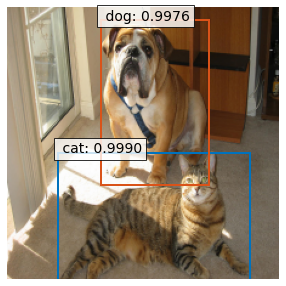

In [10]:
plot_inference(img, "cat and dog", 0.7)

## Model Interpretability Visualization with AGF

In [13]:
def get_visualization(model, mdetr_ouput, **kwargs):
    predictions = mdetr_ouput["pred_logits"]
    probabilities = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    
    # print(class_indices)
    
    max_str_len = 0
    class_names = []
    
    for class_index in class_indices[0]:
        class_name = CLS2IDX[class_index]
        class_names.append(class_name)
        max_str_len = max(max_str_len, len(class_name))
    
    print(class_names)
    
    return model.AGF(**kwargs)

In [14]:
# Apply mean-std normalization to the input image.
img_normalized = transform(img).unsqueeze(0)

caption = "cat and dog"

# Propagate through the model (forwad path)
memory_cache = model(img_normalized,
                     [caption],
                     encode_and_save=True)

outputs = model(img_normalized,
                [caption],
                encode_and_save=False,
                memory_cache=memory_cache)

dog = get_visualization(model, outputs)


dog = (render.hm_to_rgb(dog[0, 0].data.cpu().numpy(
), scaling=3, sigma=1, cmap='seismic') * 255).astype(np.uint8)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(img)
axs[0].axis('off')
axs[1].imshow(dog)
axs[1].axis('off')

['dog', 'dog', 'dog', 'water snake', 'water snake', 'water snake', 'water snake', 'water snake', 'water snake', 'dog', 'water snake', 'water snake', 'water snake', 'water snake', 'dog', 'water snake', 'dog', 'dog', 'dog', 'dog', 'water snake', 'water snake', 'dog', 'dog', 'dog', 'water snake', 'dog', 'dog', 'dog', 'dog', 'water snake', 'water snake', 'water snake', 'water snake', 'water snake', 'dog', 'dog', 'dog', 'dog', 'water snake', 'water snake', 'dog', 'ringneck snake, ring-necked snake, ring snake', 'water snake', 'dog', 'dog', 'dog', 'water snake', 'dog', 'water snake', 'water snake', 'hummingbird', 'dog', 'dog', 'water snake', 'dog', 'dog', 'dog', 'water snake', 'water snake', 'water snake', 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'water snake', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'water snake', 'dog', 'water snake', 'water snake', 'water snake', 'water snak

TypeError: 'NoneType' object is not subscriptable

In [ ]:
for key in outputs.keys():
    print(key)

pred_logits
pred_boxes
proj_queries
proj_tokens
tokenized


In [ ]:
outputs['pred_logits'].size()
# numberOfImages    numberOfPotentialObjects/BoundingBoxes      numberOfObjectClasses

torch.Size([1, 100, 256])